# Explorations in Word2Vec

#### Using the dialoge from the Simpson's

## Importing and preprocessing/cleaning the data



Data loading and model based on [this](https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial/notebook#Materials-for-more-in-depths-understanding:) tutorial.


Dataset used available on Kaggle [here](https://www.kaggle.com/code/ambarish/fun-in-text-mining-with-simpsons/data).

In [63]:
import re  # For preprocessing
import numpy as np
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [64]:
df = pd.read_csv('data/simpsons_dataset.csv')

print("Pre-cleanup:\n",df.isnull().sum(),df.shape)

df = df.dropna().reset_index(drop=True) # remove empty lines

print("\nPost-cleanup:\n",df.isnull().sum(),df.shape)

Pre-cleanup:
 raw_character_text    17814
spoken_words          26459
dtype: int64 (158314, 2)

Post-cleanup:
 raw_character_text    0
spoken_words          0
dtype: int64 (131853, 2)


In [65]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [66]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.73 mins


In [67]:
df_clean = pd.DataFrame({'clean': txt, 'character': list(df['raw_character_text'])})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(86383, 2)

## Using Gensim Phrases to discover common phrases


More available [here](https://radimrehurek.com/gensim/models/phrases.html)

In [68]:
from gensim.models.phrases import Phrases, Phraser

In [69]:
sent = [row.split() for row in df_clean['clean']] #split rows into words

In [70]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 15:15:28: collecting all words and their counts
INFO - 15:15:28: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 15:15:28: PROGRESS: at sentence #10000, processed 63507 words and 52613 word types
INFO - 15:15:28: PROGRESS: at sentence #20000, processed 130769 words and 99329 word types
INFO - 15:15:28: PROGRESS: at sentence #30000, processed 192661 words and 137759 word types
INFO - 15:15:28: PROGRESS: at sentence #40000, processed 249531 words and 171589 word types
INFO - 15:15:28: PROGRESS: at sentence #50000, processed 310670 words and 207124 word types
INFO - 15:15:28: PROGRESS: at sentence #60000, processed 372917 words and 242083 word types
INFO - 15:15:28: PROGRESS: at sentence #70000, processed 435619 words and 276832 word types
INFO - 15:15:28: PROGRESS: at sentence #80000, processed 496902 words and 309687 word types
INFO - 15:15:28: collected 329641 token types (unigram + bigrams) from a corpus of 538664 words and 86383 sentences
INFO - 15:15:28: m

Reformat the corpus using the detected ~130 bigrams

In [71]:
bigram = Phraser(phrases)
sentences = bigram[sent]


INFO - 15:15:29: exporting phrases from Phrases<329641 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 15:15:29: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<131 phrases, min_count=30, threshold=10.0> from Phrases<329641 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.33s', 'datetime': '2023-01-30T15:15:29.342511', 'gensim': '4.3.0', 'python': '3.8.15 | packaged by conda-forge | (default, Jan 26 2023, 10:51:07) \n[Clang 14.0.6 ]', 'platform': 'macOS-13.0.1-arm64-i386-64bit', 'event': 'created'}


#### Most frequent words:

In [72]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq), np.array(sorted(word_freq, key=word_freq.get, reverse=True)).T[:10]

(29697,
 array(['oh', 'like', 'know', 'get', 'hey', 'think', 'come', 'right',
        'look', 'want'], dtype='<U71'))

# Training the model



The followed tutorial did this in 3 steps:

(1.) setup parameters
(2.) build vocabulary
(3.) train model

In [73]:
import multiprocessing

from gensim.models import Word2Vec

In [74]:
cores = multiprocessing.cpu_count()
cores

8

### (1) Parameters

- min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)


- window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)


- size = int - Dimensionality of the feature vectors. - (50, 300)


- sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)


- alpha = float - The initial learning rate - (0.01, 0.05)


- min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00


- negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)


- workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [75]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

INFO - 15:15:29: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2023-01-30T15:15:29.772781', 'gensim': '4.3.0', 'python': '3.8.15 | packaged by conda-forge | (default, Jan 26 2023, 10:51:07) \n[Clang 14.0.6 ]', 'platform': 'macOS-13.0.1-arm64-i386-64bit', 'event': 'created'}


### (2) Building the vocabulary

In [76]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:15:29: collecting all words and their counts
INFO - 15:15:29: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 15:15:29: PROGRESS: at sentence #10000, processed 61631 words, keeping 9513 word types
INFO - 15:15:29: PROGRESS: at sentence #20000, processed 127112 words, keeping 14361 word types
INFO - 15:15:29: PROGRESS: at sentence #30000, processed 187410 words, keeping 17412 word types
INFO - 15:15:29: PROGRESS: at sentence #40000, processed 242868 words, keeping 20077 word types
INFO - 15:15:29: PROGRESS: at sentence #50000, processed 302411 words, keeping 22481 word types
INFO - 15:15:30: PROGRESS: at sentence #60000, processed 363076 words, keeping 24779 word types
INFO - 15:15:30: PROGRESS: at sentence #70000, processed 424337 words, keeping 26930 word types
INFO - 15:15:30: PROGRESS: at sentence #80000, processed 484273 words, keeping 28749 word types
INFO - 15:15:30: collected 29697 word types from a corpus of 524821 raw words and 86383 sentence

Time to build vocab: 0.01 mins


### (3) Training the model

In [77]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:15:30: Word2Vec lifecycle event {'msg': 'training model with 7 workers on 3332 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2 shrink_windows=True', 'datetime': '2023-01-30T15:15:30.182097', 'gensim': '4.3.0', 'python': '3.8.15 | packaged by conda-forge | (default, Jan 26 2023, 10:51:07) \n[Clang 14.0.6 ]', 'platform': 'macOS-13.0.1-arm64-i386-64bit', 'event': 'train'}
INFO - 15:15:30: EPOCH 0: training on 524821 raw words (199735 effective words) took 0.5s, 395634 effective words/s
INFO - 15:15:31: EPOCH 1: training on 524821 raw words (200263 effective words) took 0.6s, 317370 effective words/s
INFO - 15:15:31: EPOCH 2: training on 524821 raw words (199463 effective words) took 0.6s, 317918 effective words/s
INFO - 15:15:32: EPOCH 3: training on 524821 raw words (200147 effective words) took 0.5s, 380728 effective words/s
INFO - 15:15:33: EPOCH 4: training on 524821 raw words (200019 effective words) took 0.6s, 330072 effective words/s
INFO - 

Time to train the model: 0.29 mins


# Explorations on the trained model

## Following the tutorial

Determine similarity between two words

In [78]:
w2v_model.wv.similarity('maggie','baby')

0.6375271

Look at most similar 10 words (this is not the what homer says, but is said about homer)

In [79]:
w2v_model.wv.most_similar(positive=["homer"])

[('marge', 0.7296507954597473),
 ('crummy', 0.690354585647583),
 ('terrific', 0.6790673732757568),
 ('sake', 0.6769735813140869),
 ('sweetheart', 0.6709840297698975),
 ('creepy', 0.670829713344574),
 ('fault', 0.6707740426063538),
 ('gee', 0.6679732799530029),
 ('convince', 0.6674911975860596),
 ('shoulda', 0.6673606038093567)]

In [80]:
w2v_model.wv.most_similar(positive=["marge", "woman"], negative=["homer"])

[('marriage', 0.6442464590072632),
 ('marry', 0.6088236570358276),
 ('attractive', 0.6031028628349304),
 ('decent', 0.579098105430603),
 ('happiness', 0.5763802528381348),
 ('imagine', 0.5719634294509888),
 ('someday', 0.5607335567474365),
 ('romance', 0.5605749487876892),
 ('ashamed', 0.5574089288711548),
 ('creation', 0.5556820631027222)]

## Looking into visualisation


Modified the code from [here](
https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py)

In [81]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

t = time()

def reduce_dimensions(model):
    num_dimensions = 3  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(w2v_model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


plot_function = plot_with_plotly

plot_function(x_vals, y_vals, labels)

print('Time to plot: {} mins'.format(round((time() - t) / 60, 2)))

Time to plot: 0.33 mins


### Next from the tutorial

In [82]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=2).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

#### Comparing words most similar to Maggie to words most dissimilar

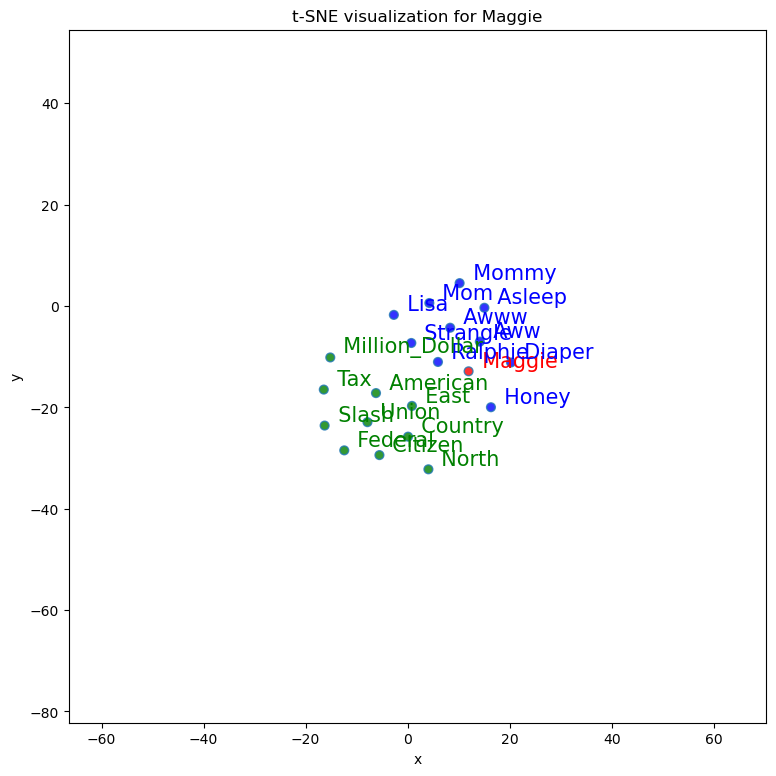

In [83]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

## Aggregating the dialoges by characters

### Aggregate the dataframe

In [24]:
corpus_by_speaker = df_clean.groupby(by='character',as_index=False).agg({ 'character' : 'first','clean' : ' '.join})
corpus_by_speaker['clean'] = corpus_by_speaker['clean'].str.split()


len(corpus_by_speaker['clean'].iloc[3089])

650

### Vectorizing lists of character speeches

Based on what a character said, we can generate an overall sentiment of what he/she/it said. This is (for simplicity) represented by the average of the vector representation of words in their dialouge.

Using [this](https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/) simple code I found originally intended for categorising documents



In [25]:
def vectorize(list_of_docs, model):
    
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

vectorised_by_speaker = vectorize(corpus_by_speaker['clean'], w2v_model)
    

### Plotting the vectors of each character

There are 5000+ characters, thus this plot is quite full too.

In [26]:
def squash_to_plot(vectorised_by_speaker, corpus_by_speaker):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(vectorised_by_speaker)
    labels = np.asarray(corpus_by_speaker)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

x, y, labels = squash_to_plot(vectorised_by_speaker, corpus_by_speaker['character'])

plot_function(x, y, labels)


### Clustering characters based on their dialoges

Using sklearn simply. More [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans)

In [27]:
from sklearn.cluster import MiniBatchKMeans

In [28]:
vectorised_by_speaker = np.array(vectorised_by_speaker)

kmeans = MiniBatchKMeans(n_clusters=46,
                        random_state=0,
                        batch_size=32,
                        max_iter=20,
                        n_init="auto").fit(vectorised_by_speaker,y=labels)



In [29]:
assignments = pd.DataFrame({'character': labels,'group': kmeans.labels_})

assignments.groupby('group').count().sort_values(by='character',ascending=False)[:10]

,character
group,
18,817
9,435
26,403
16,337
25,224
1,222
19,209
34,174
11,169


In [30]:
assignments[assignments['character'].str.contains("Homer")].sort_values(by='group')

,character,group
4943,Walrus Homer,1
1526,Evil Homer,2
2196,Homer's Stomach,3
2185,Homer Puppet,4
4176,Serious Homer,5
1801,Future Homer,6
4253,Simulated Homer,8
3622,Pieces Of Homer,8
4888,Viking Homer,9
2194,Homer's Recording,9


In [31]:
assignments[assignments['character'].str.contains("Homer")].sort_values(by='group').groupby('group').count()

,character
group,
1,1
2,1
3,1
4,1
5,1
6,1
8,2
9,3
16,5


In [32]:
assignments[assignments['group']==24]

,character,group
1,'70s Announcer,24
50,2nd Film Loop,24
94,8-Year-Old Barney,24
487,Bearded Hillbilly,24
621,Brave,24
736,COWBOY,24
839,Celebrity Reporter,24
964,Clearly Dubbed-in Voice,24
1030,Concert Announcer,24
1120,Crowd Of Nerds,24


In [33]:
w2v_model.wv.add_vectors(labels,vectorised_by_speaker)


In [34]:
vectorised_by_speaker[0]

array([-0.00921022,  0.10419817, -0.00119128,  0.10980397, -0.09815206,
       -0.33815238,  0.09514782,  0.23492317,  0.13293365, -0.1603879 ,
       -0.0792727 , -0.23800761,  0.09666447, -0.05570195, -0.17878085,
       -0.11330238,  0.05070034,  0.0414032 ,  0.09574859,  0.04335215,
       -0.36689258, -0.263235  ,  0.22479586,  0.13583763,  0.16247654,
        0.10664769,  0.01920194,  0.27285033, -0.09057055, -0.13521487,
       -0.19101951, -0.25914732,  0.10754621, -0.03021866, -0.3312411 ,
        0.00505272,  0.06724041, -0.19568557,  0.03195431, -0.07415652,
       -0.00697435,  0.02234495, -0.01398416, -0.29530066,  0.01913457,
        0.16247284, -0.16150093,  0.12680504, -0.16519126,  0.2794795 ,
        0.12628818,  0.11321563,  0.10278496, -0.0170367 , -0.06335723,
        0.25264409, -0.18781617, -0.21462604,  0.11101262, -0.17369944,
       -0.09457278,  0.00461685,  0.0116825 ,  0.075903  ,  0.06651075,
       -0.04972224,  0.11444408, -0.02374443, -0.01982273, -0.09

In [61]:
vector = w2v_model.wv.infer_vector(doc_words = corpus_by_speaker['clean'].iloc[0])

AttributeError: 'KeyedVectors' object has no attribute 'infer_vector'

In [39]:
w2v_model.wv.add_vectors(,vectorised_by_speaker, replace=False)

In [56]:
w2v_model.wv.similar_by_word("1-Year-Old Bart","teacher")

IndexError: index 3334 is out of bounds for axis 0 with size 3332

In [54]:
labels

array(["'30s Reporter", "'70s Announcer", '1-Year-Old Bart', ...,
       'newsstand Operator', 'teacher', 'Ãœter'], dtype=object)

In [57]:
len(labels)

5139

In [59]:
len(corpus_by_speaker['clean'])

5139

['kinda', 'get', 'mr', 'burn']